# Set-Based Neural Network Training with PyTorch

In this notebook, I will show you how to train a neural network using set-based computation. This is a simple example to show you how to use set-based data in PyTorch.

In [1]:
# Importing the libraries
from copy import deepcopy
import torch    
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from SBML import PyTorchZonotope as ptz

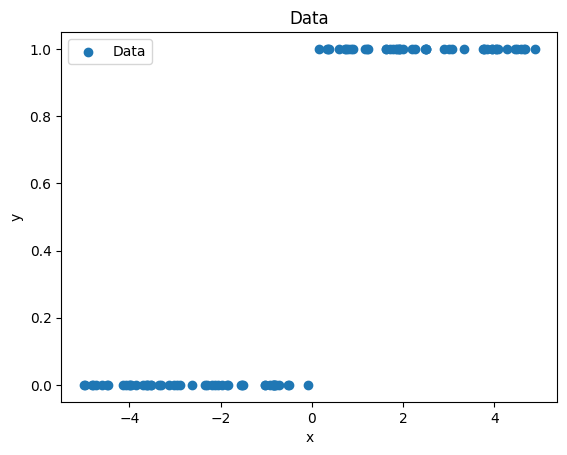

In [2]:
# Generating the input data
np.random.seed(1)
torch.manual_seed(1)

num_samples = 100

x = np.random.rand(num_samples, 1) * 10 - 5
y = (np.sign(x) + 1)/2

# Plotting the data
plt.scatter(x, y, label='Data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.show()


In [3]:
# Initializing the model

nn = torch.nn.Sequential(
    torch.nn.Linear(1, 400),
    torch.nn.ReLU(),
    torch.nn.Linear(400, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, 2),
    torch.nn.Softmax()
)

# Initialize weights using Xavier initialization
for layer in nn:
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        torch.nn.init.zeros_(layer.bias)

In [4]:
# Training the model
# Use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Duplicating model
nn_point = deepcopy(nn)
nn_point = nn_point.to(device)
nn_set = deepcopy(nn)
nn_set = nn_set.to(device)

# Load the data
x = torch.tensor(x, dtype=torch.float32).to(device)
y = torch.tensor(y.squeeze(), dtype=torch.long).to(device)

In [5]:
# Loss function
loss_point = torch.nn.CrossEntropyLoss()
loss_set = ptz.core.ZonotopeClassificationLoss(1e-3,1e-3)

# Optimizer
optimizer_point = torch.optim.Adam(nn_point.parameters(), lr=0.01)
optimizer_set = torch.optim.Adam(nn_set.parameters(), lr=0.01)

# Training the model
nn_point_trained = ptz.functions.train(nn_point, loss_point, optimizer_point, x, y, 100, batchsize=64)
nn_set_trained = ptz.functions.train(nn_set, loss_set, optimizer_set, x, y, 100, batchsize=64, noise=1e-3)

_____________________________________
 Neural Network Training Paramteres: 
-------------------------------------
Training Parameters:
	 Epochs   100
	 Batchsize   64
	 Perturbation Radius   0.0
______________________________________
|Epoch	|Time	|Loss
--------------------------------------
| 0 	|0.1 	|0.7 	|
| 1 	|0.1 	|0.4 	|
| 2 	|0.1 	|0.3 	|
| 3 	|0.1 	|0.3 	|
| 4 	|0.1 	|0.3 	|
| 5 	|0.1 	|0.3 	|
| 6 	|0.1 	|0.3 	|
| 7 	|0.1 	|0.3 	|
| 8 	|0.1 	|0.3 	|
| 9 	|0.1 	|0.3 	|
| 10 	|0.1 	|0.3 	|
| 11 	|0.1 	|0.3 	|
| 12 	|0.1 	|0.3 	|
| 13 	|0.1 	|0.3 	|
| 14 	|0.1 	|0.3 	|
| 15 	|0.1 	|0.3 	|
| 16 	|0.1 	|0.3 	|
| 17 	|0.1 	|0.3 	|
| 18 	|0.1 	|0.3 	|
| 19 	|0.1 	|0.3 	|
| 20 	|0.1 	|0.3 	|
| 21 	|0.1 	|0.3 	|
| 22 	|0.2 	|0.3 	|
| 23 	|0.2 	|0.3 	|
| 24 	|0.2 	|0.3 	|
| 25 	|0.2 	|0.3 	|
| 26 	|0.2 	|0.3 	|
| 27 	|0.2 	|0.3 	|
| 28 	|0.2 	|0.3 	|
| 29 	|0.2 	|0.3 	|
| 30 	|0.2 	|0.3 	|
| 31 	|0.2 	|0.3 	|
| 32 	|0.2 	|0.3 	|
| 33 	|0.2 	|0.3 	|
| 34 	|0.2 	|0.3 	|
| 35 	|0.2 	|0.3 	

/home/manuel/ETH_Code/SemProj/SetBasedRL/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


| 99 	|0.2 	|0.3 	|
_____________________________________
 Neural Network Training Paramteres: 
-------------------------------------
Training Parameters:
	 Epochs   100
	 Batchsize   64
	 Perturbation Radius   0.001
______________________________________
|Epoch	|Time	|Loss
--------------------------------------
| 0 	|0.07 	|-0.1 	|
| 1 	|0.08 	|-0.06 	|
| 2 	|0.1 	|-0.06 	|
| 3 	|0.1 	|-0.07 	|
| 4 	|0.1 	|-0.07 	|
| 5 	|0.1 	|-0.06 	|
| 6 	|0.2 	|-0.06 	|
| 7 	|0.2 	|-0.07 	|
| 8 	|0.2 	|-0.06 	|
| 9 	|0.2 	|-0.06 	|
| 10 	|0.2 	|-0.06 	|
| 11 	|0.2 	|-0.07 	|
| 12 	|0.2 	|-0.07 	|
| 13 	|0.2 	|-0.07 	|
| 14 	|0.3 	|-0.07 	|
| 15 	|0.3 	|-0.09 	|
| 16 	|0.3 	|-0.08 	|
| 17 	|0.3 	|-0.09 	|
| 18 	|0.3 	|-0.1 	|
| 19 	|0.3 	|-0.1 	|
| 20 	|0.3 	|-0.09 	|
| 21 	|0.3 	|-0.09 	|
| 22 	|0.4 	|-0.09 	|
| 23 	|0.4 	|-0.08 	|
| 24 	|0.4 	|-0.09 	|
| 25 	|0.4 	|-0.08 	|
| 26 	|0.4 	|-0.09 	|
| 27 	|0.4 	|-0.09 	|
| 28 	|0.4 	|-0.09 	|
| 29 	|0.4 	|-0.09 	|
| 30 	|0.5 	|-0.09 	|
| 31 	|0.5 	|-0

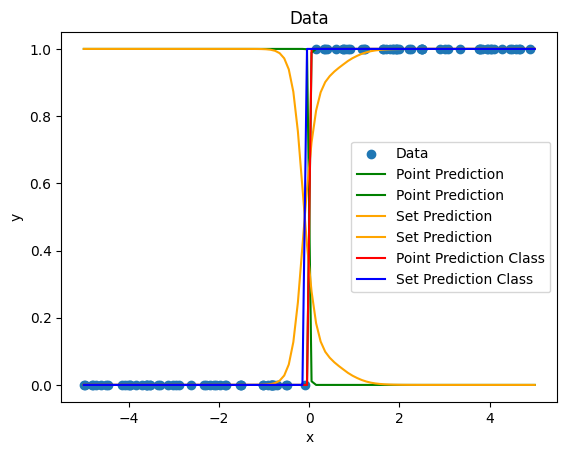

In [6]:
# Plotting the results

x_test = torch.linspace(-5, 5, 100).view(-1, 1).to(device)
y_pred_point = nn_point_trained(x_test)
y_pred_set = nn_set_trained(x_test)

plt.scatter(x.detach().cpu(), y.detach().cpu(), label='Data')
plt.plot(x_test.detach().cpu(), y_pred_point.detach().cpu(), color ='green',label='Point Prediction')
plt.plot(x_test.detach().cpu(), y_pred_set.detach().cpu(), color = 'orange', label='Set Prediction')
plt.plot(x_test.detach().cpu(), torch.argmax(y_pred_point, dim=1).detach().cpu(), color = 'red', label='Point Prediction Class')
plt.plot(x_test.detach().cpu(), torch.argmax(y_pred_set, dim=1).detach().cpu(), color = 'blue', label='Set Prediction Class')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.show()